In [ ]:
!pip install deepface yt-dlp opencv-python-headless mtcnn

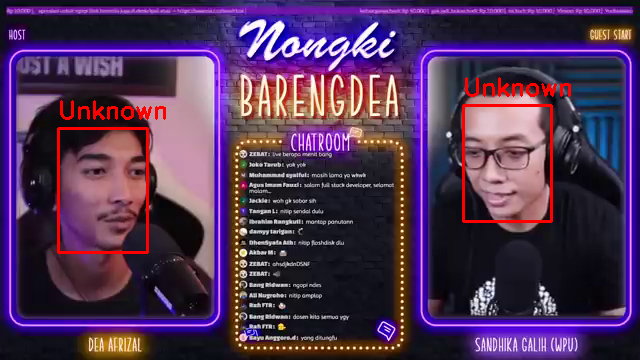

🔴 Video selesai setelah 40 detik.
📸 Menampilkan semua hasil capture...


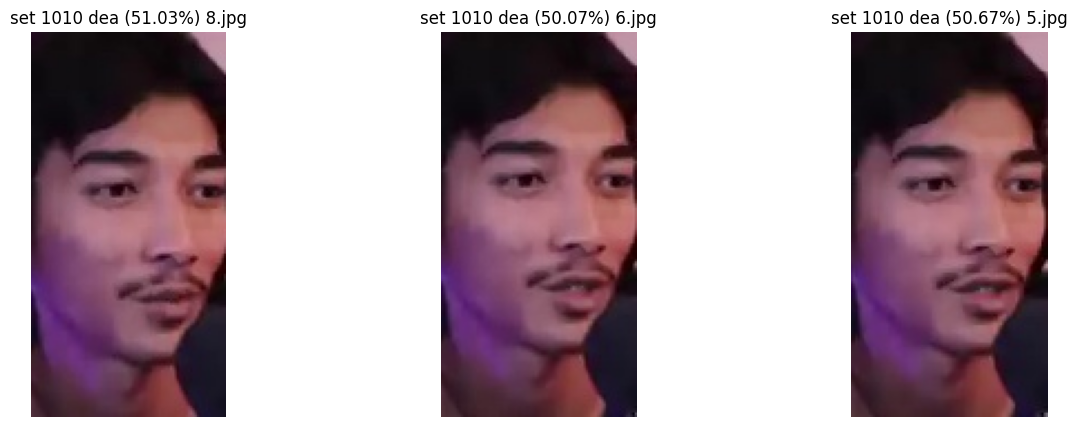

📸 Menampilkan semua frame yang disimpan...


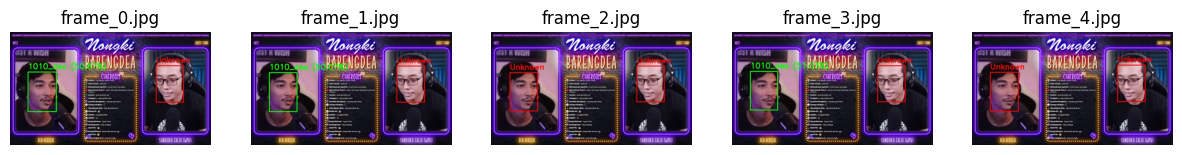

In [ ]:
import cv2
import numpy as np
import yt_dlp
from deepface import DeepFace
import os
import time
from google.colab.patches import cv2_imshow
from IPython.display import clear_output
import matplotlib.pyplot as plt
from mtcnn import MTCNN  # Import MTCNN untuk deteksi wajah

# 🟢 **Fungsi untuk Memuat Gambar Referensi**
def load_reference_images():
    reference_images = []
    reference_names = []

    for filename in os.listdir():
        if filename.endswith(".jpg") and "_" in filename:  # Format "NIP_Nama.jpg"
            img = cv2.imread(filename)
            if img is not None:
                reference_images.append(img)
                reference_names.append(filename.replace(".jpg", ""))

    return reference_images, reference_names

# 🟢 **Fungsi untuk Mendapatkan URL Video YouTube**
def get_video_url(youtube_url):
    ydl_opts = {'format': 'best'}
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(youtube_url, download=False)
        return info['url']

# 🟢 **Fungsi untuk Mendeteksi Wajah & Simpan Capture menggunakan MTCNN**
import cv2
import numpy as np
import yt_dlp
from deepface import DeepFace
import os
import time
from google.colab.patches import cv2_imshow
from IPython.display import clear_output
import matplotlib.pyplot as plt
from mtcnn import MTCNN

def load_reference_images():
    reference_images = []
    reference_names = []

    for filename in os.listdir():
        if filename.endswith(".jpg") and "_" in filename:
            img = cv2.imread(filename)
            if img is not None:
                reference_images.append(img)
                reference_names.append(filename.replace(".jpg", ""))

    return reference_images, reference_names

def get_video_url(youtube_url):
    ydl_opts = {'format': 'best'}
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(youtube_url, download=False)
        return info['url']

import cv2
import numpy as np
import yt_dlp
from deepface import DeepFace
import os
import time
from google.colab.patches import cv2_imshow
from IPython.display import clear_output
import matplotlib.pyplot as plt
from mtcnn import MTCNN

def load_reference_images():
    reference_images = []
    reference_names = []

    for filename in os.listdir():
        if filename.endswith(".jpg") and "_" in filename:
            img = cv2.imread(filename)
            if img is not None:
                reference_images.append(img)
                reference_names.append(filename.replace(".jpg", ""))

    return reference_images, reference_names

def get_video_url(youtube_url):
    ydl_opts = {'format': 'best'}
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(youtube_url, download=False)
        return info['url']

def recognize_faces_mtcnn(frame, reference_images, reference_names, capture_count):
    matches = []
    detector = MTCNN()  # Inisialisasi MTCNN tanpa parameter tambahan

    # Tingkatkan kontras gambar
    lab = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    enhanced_frame = cv2.merge((cl,a,b))
    enhanced_frame = cv2.cvtColor(enhanced_frame, cv2.COLOR_LAB2BGR)

    # Atur parameter deteksi yang lebih sensitif
    faces = detector.detect_faces(enhanced_frame)

    for face in faces:
        if face['confidence'] < 0.9:  # Filter wajah dengan confidence rendah
            continue

        x, y, w, h = face['box']

        # Perluas area wajah untuk mencakup kacamata
        expanded_y = max(0, y - int(0.2 * h))
        expanded_h = int(1.4 * h)
        expanded_w = min(frame.shape[1] - x, w)  # Pastikan tidak melebihi lebar frame
        face_img = frame[expanded_y:expanded_y+expanded_h, x:x+expanded_w]

        if face_img.size == 0 or face_img.shape[0] == 0 or face_img.shape[1] == 0:
            continue

        matched_name = "Unknown"
        best_similarity = 0

        for idx, ref_img in enumerate(reference_images):
            try:
                # Konfigurasi DeepFace untuk lebih toleran
                result = DeepFace.verify(
                    face_img,
                    ref_img,
                    enforce_detection=False,
                    model_name="VGG-Face",
                    distance_metric="cosine"
                )

                if result['verified']:
                    similarity = (1 - result['distance']) * 100
                    if similarity > best_similarity and similarity > 50:  # Tambah threshold minimal
                        best_similarity = similarity
                        matched_name = f"{reference_names[idx]} ({similarity:.2f}%)"
            except Exception as e:
                continue

        matches.append((x, y, w, h, matched_name))

        # Hanya simpan wajah yang dikenali (bukan Unknown)
        if "Unknown" not in matched_name:
            if not os.path.exists("data"):
                os.makedirs("data")

            filename = f"data/set_{matched_name.replace(' ', '_')}_{capture_count}.jpg"
            cv2.imwrite(filename, face_img)

    return matches

# Sisanya kode tetap sama seperti sebelumnya...

# 🟢 **Setup Video Streaming**
url = "https://www.youtube.com/live/nww7nBlOvKA?si=JpEpt-S6jLufCvZ5"  # Gantilah dengan video YouTube biasa
max_duration = 40  # Batas waktu dalam detik
capture_count = 5  # Hitungan capture wajah

print(f"🔄 Memulai video...")
video_url = get_video_url(url)
start_time = time.time()

if video_url:
    cap = cv2.VideoCapture(video_url)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

    reference_images, reference_names = load_reference_images()

    frame_counter = 0  # Untuk menyimpan frame

    if not os.path.exists("frames"):
        os.makedirs("frames")

    while cap.isOpened():
        elapsed_time = time.time() - start_time
        if elapsed_time > max_duration:
            print(f"🔴 Video selesai setelah {max_duration} detik.")
            break

        ret, frame = cap.read()
        if not ret:
            break

        detected_faces = recognize_faces_mtcnn(frame, reference_images, reference_names, capture_count)

        for (x, y, w, h, name) in detected_faces:
            color = (0, 255, 0) if name != "Unknown" else (0, 0, 255)
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            cv2.putText(frame, name, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

        # Simpan setiap frame ke folder
        frame_filename = f"frames/frame_{frame_counter}.jpg"
        cv2.imwrite(frame_filename, frame)
        frame_counter += 1

        # Tampilkan frame (Colab hanya bisa satu gambar per detik)
        clear_output(wait=True)
        cv2_imshow(frame)
        capture_count += 1

        if cv2.waitKey(30) & 0xFF == ord('q'):
            cap.release()
            cv2.destroyAllWindows()
            exit()

    cap.release()
    cv2.destroyAllWindows()
else:
    print("❌ Gagal mengambil video dari YouTube")

# 🟢 **Menampilkan Semua Hasil Capture Setelah Video Berhenti**
print("📸 Menampilkan semua hasil capture...")

captured_images = [f for f in os.listdir("data") if f.endswith(".jpg")]

if len(captured_images) > 0:
    fig, axes = plt.subplots(nrows=1, ncols=min(5, len(captured_images)), figsize=(15, 5))

    if len(captured_images) == 1:
        axes = [axes]  # Jika hanya satu gambar, ubah menjadi list

    for idx, filename in enumerate(captured_images[:5]):  # Batasi ke 5 hasil terbaik
        img = cv2.imread(os.path.join("data", filename))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axes[idx].imshow(img_rgb)
        axes[idx].axis("off")
        axes[idx].set_title(filename.replace("data/", "").replace("_", " "))

    plt.show()
else:
    print("❌ Tidak ada wajah yang terdeteksi.")

# 🟢 **Menampilkan Semua Frame yang Disimpan**
print("📸 Menampilkan semua frame yang disimpan...")

frame_files = sorted([f for f in os.listdir("frames") if f.endswith(".jpg")])

if len(frame_files) > 0:
    fig, axes = plt.subplots(nrows=1, ncols=min(5, len(frame_files)), figsize=(15, 5))

    if len(frame_files) == 1:
        axes = [axes]

    for idx, filename in enumerate(frame_files[:5]):  # Batasi ke 5 frame
        img = cv2.imread(os.path.join("frames", filename))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axes[idx].imshow(img_rgb)
        axes[idx].axis("off")
        axes[idx].set_title(filename.replace("frames/", ""))

    plt.show()
else:
    print("❌ Tidak ada frame yang tersimpan.")
